L'objectif de ce projet est de comparer les temps de trajet en voiture ou en vélo (avec assistance électrique ou non) pour les trajets du quotidien (par exemple, pour faire des courses) en France métropolitaine.
Il s'agit aussi de comparer ces moyens de transports dans différents environnements : on s'attend à ce que le vélo soit efficace dans les grandes villes, mais à quel point est-il efficace dans les petites villes et les villages ?

Afin de comparer l'efficacité de la voiture et des deux types de vélo, nous allons prendre un type de commerce, par exemple les supermarchés.
Pour chaque supermarché, nous allons calculer une isochrone selon les modes de transports que nous comparons, et selon des intervalles de temps. Une isochrone permet de déterminer quelle zone géographique est atteignable en un temps donné selon un mode de déplacement.

Ensuite, nous allons fusionner tous ces isochrones pour chaque intervalle de temps et chaque mode de transport. Nous allons obtenir des cartes isochrones de la France métropolitaine qui represéntent toutes les zones géographiques étant à 5/10/15/20/25/30 minutes d'au moins un supermarché en vélo/vélo électrique/voiture.

Enfin, nous superposons ces cartes isochrones à la carte de la répartition de la population françaises, et à la carte des communes.

#### Source des données externes :


| Description | Version utilisée |
|-------------|--------------|
| Contour des communes françaises / Format GeoJSON [[Lien]](https://data-interne.ademe.fr/datasets/geo-contours-communes)| 25/04/2025 | 
| Contour de la France métropolitaine [[Lien]](https://github.com/gregoiredavid/france-geojson/blob/master/metropole.geojson)| 01/08/2018 | 
| Répartition de la population de France métropolitaine en 2020 / Format WGS84 / 3 arcsec [[Lien]](https://human-settlement.emergency.copernicus.eu/download.php) | 2023 | 
| Liste des commerces français d'OpenStreetMap [[Lien]](https://public.opendatasoft.com/explore/dataset/osm-france-shop-craft-office/information/)| 09/07/2025 |
|||
| OpenRouteService, un service permettant de calculer des itinéraires, et notamment des isochrones [[Lien]](https://github.com/GIScience/openrouteservice)| 06/06/2025 |
| Données OpenStreetMap pour la France métropolitaine. Utilisé uniquement par l'instance locale d'OpenRouteService [[Lien]](https://download.geofabrik.de/europe/france.html)| 07/2025|

In [2]:
import geopandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import duckdb

import time
import requests

import xarray
import rioxarray
import rasterio

from shapely import wkt, Polygon, geometry
import shapely.plotting

from rasterio.plot import show
import matplotlib.colors as colors

#### Création dossiers locaux

In [4]:
import os

shops = ('bakery', 'supermarket')
mobilities = ('driving-car', 'cycling-regular', 'cycling-electric')

for shop in shops:
    for mobility in mobilities:
        os.makedirs(f"processed/{mobility}/{shop}", exist_ok = True)

os.makedirs(f"processed/population/communes", exist_ok = True)
os.makedirs(f"processed/data", exist_ok = True)

# Partie 1 : Préparation des données

Cette partie n'a besoin que d'être lancée une seule fois.

#### Création de la carte de la population de la France métropolitaine

Nous regroupons les données du Global Human Settlement (GHS) en une seule image, et nous gardons que les données de population de la France métropolitaine.

In [3]:
x1 = xarray.open_dataset("data_ext/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_R4_C18.tif")
x2 = xarray.open_dataset("data_ext/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_R4_C19.tif")
x3 = xarray.open_dataset("data_ext/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_R5_C18.tif")
x4 = xarray.open_dataset("data_ext/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_R5_C19.tif")

In [4]:
rx1 = xarray.concat([x1, x2], dim='x')
rx2 = xarray.concat([x3, x4], dim='x')
rx  = xarray.concat([rx1, rx2], dim='y')

In [5]:
coords = {
    'band' : rx.band,
    'x' : rx.x[5500:],
    'y' : rx.y[9500:22000]
}
pop_fr_large = xarray.Dataset(coords=coords, data_vars=rx.data_vars)

In [6]:
pop_fr_large.to_dataarray()[0][0].rio.to_raster("processed/population/POP_FRANCE_LARGE.tif")

In [7]:
france_metro = geopandas.read_file('data_ext/metropole.geojson')

In [8]:
with rasterio.open("processed/population/POP_FRANCE_LARGE.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, france_metro["geometry"], crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("processed/population/POP_FRANCE_METRO.tif", "w", **out_meta) as dest:
    dest.write(out_image)

#### Création de la table avec les populations pour chaque commune

In [53]:
df = geopandas.read_file("data_ext/GEO_Contours_Communes_2025.geojson")

# Enlever les territoires hors métropole
df = df[~df["REGION_COD"].isin(["00", "01", "02", "03", "04", "06"])]
# Enlever les arrondissements de Paris, Lyon, Marseille (les villes entières sont déjà présentes)
df = df[~df["DCOE_L_LIB"].str.contains("Arrondissement")]

In [54]:
for i in df.index:
    mask = df.loc[i, "geometry"]
    if mask:
        if mask.geom_type == "GeometryCollection":
            df.loc[i, "geometry"] = mask.geoms[0]

In [55]:
df = df.reset_index(drop=True)
df_communes = df

In [57]:
src = rasterio.open("processed/population/POP_FRANCE_METRO.tif")

for i in df_communes.index:
    mask = df_communes.iloc[i]["geometry"]
    
    if mask: #en cas de None, ex : île des faisans
        out_image, out_transform = rasterio.mask.mask(src, [mask], crop=True, all_touched=True)
        out_meta = src.meta
    
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
    
        with rasterio.open(f"processed/population/communes/{i}.tif", "w", **out_meta) as dest:
            dest.write(out_image)

In [ ]:
# Prends du temps (quelques heures)

for i in df_communes.index:
    try:
        with rioxarray.open_rasterio(f"processed/population/communes/{i}.tif") as rds:
            rds.name = "data"
            pop_grille_commune = rds.to_dataframe().reset_index()

            pad = 0.000416
            s = 0
            #p_list = []
            zone_commune = df.loc[i, "geometry"]
            
            for j in pop_grille_commune.index:
                if pop_grille_commune.loc[j, "data"] > 0:
                    pop_location = pop_grille_commune.loc[j]
                    x, y = round(pop_location["x"],6), round(pop_location["y"],6)
                    p = geometry.Polygon([(x-pad, y+pad), (x+pad, y+pad), (x+pad, y-pad), (x-pad, y-pad)])
                    #p_list.append(p)
                    s += pop_location["data"]*(p.intersection(zone_commune).area / p.area)

            df_communes.loc[i, "population"] = s
            
    except:
        print(f"Pas de fichier pour la commune {i}")
        continue
    if i%500 == 0:
        print(f"Step {i}", end='\r')

In [ ]:
df["population"].sum()

In [ ]:
df_communes.to_csv(f"processed/data/pop_iso_communes.csv", index=False)

# Partie 2 : Obtention des isochrones avec OpenRouteService via Docker

Dans cette partie, nous utilisons une instance locale d'OpenRouteService via Docker.
Nous allons calculer les isochrones pour tous les commerces des catégories qui nous intéressent (supermarchés, boulangeries), 
pour chaque type de déplacement (voiture, vélo et vélo électrique), et pour des intervalles de temps (de 5 à 30 minutes).

In [9]:
#shop_type = 'supermarket'
shop_type = 'bakery'

#mobility_type = 'cycling-regular'
#mobility_type = 'cycling-electric'
mobility_type = 'driving-car'

#### Appel à la base de données des commerces d'OpenStreetMap pour récupérer les commerces selon leur type

In [10]:
# Récupération des données depuis les données d'OpenStreetMap

conn = duckdb.connect(database="data_ext/osm_shops.db")
db_relation = conn.read_csv("data_ext/osm-shop-fr@babel.csv")

df = conn.sql(
    f"""
    SELECT type, name, brand, operator, region, departement, commune, code_commune, "Geo Point"
    FROM db_relation
    WHERE type LIKE '{shop_type}'
    """
).df()

conn.close()

In [11]:
# Création d'une nouvelle colonne permettant d'utiliser la latitude / longitude lorsqu'on appelle l'API d'ORS

list_geo_point_float = []
for d in df['Geo Point']:
    list_geo_point_float.append([float(x) for x in d.split(', ')][::-1])
df["geo_point_float"] = list_geo_point_float

In [12]:
df

,type,name,brand,operator,region,departement,commune,code_commune,Geo Point,geo_point_float
0,bakery,Boulangerie Patisserie Martins,None,None,Auvergne-Rhône-Alpes,Haute-Savoie,Doussard,74104,"45.775123500375926, 6.2200735","[6.2200735, 45.775123500375926]"
1,bakery,Grandjean Jean-Marie & Nathalie,None,None,Auvergne-Rhône-Alpes,Haute-Loire,Vorey,43267,"45.18623730044939, 3.9092334","[3.9092334, 45.18623730044939]"
2,bakery,Le Fournil du Mitron,None,None,Auvergne-Rhône-Alpes,Haute-Savoie,Les Gets,74134,"46.160040200316956, 6.6722228","[6.6722228, 46.160040200316956]"
3,bakery,La Miche Au Vieux Four,None,None,Auvergne-Rhône-Alpes,Rhône,Lyon,69123,"45.754738100378816, 4.8470185","[4.8470185, 45.754738100378816]"
4,bakery,None,None,None,Provence-Alpes-Côte d'Azur,Vaucluse,Malaucène,84069,"44.17375580052592, 5.1328882","[5.1328882, 44.17375580052592]"
...,...,...,...,...,...,...,...,...,...,...
29183,bakery,Festival des Pains,None,None,Auvergne-Rhône-Alpes,Allier,Le Veurdre,03309,"46.756554680696325, 3.0405306833101458","[3.0405306833101458, 46.756554680696325]"
29184,bakery,Les délices de Thomas,None,None,Grand Est,Ardennes,Villers-Semeuse,08480,"49.74235059951193, 4.7414922","[4.7414922, 49.74235059951193]"
29185,bakery,Artisan Boulanger et Patissier,None,None,Centre-Val de Loire,Loiret,Saint-Denis-en-Val,45274,"47.877854899966636, 1.9569897","[1.9569897, 47.877854899966636]"
29186,bakery,Maison Vatelier,None,None,Normandie,Seine-Maritime,Quincampoix,76517,"49.52272099956426, 1.1868131","[1.1868131, 49.52272099956426]"


#### Calcul des isochrones, appel de l'API locale d'OpenRouteService

In [25]:
def call_local_ors_api(geo_point, time_ranges, mobility_type):

    if mobility_type == "driving-car":
        options = {"avoid_features":["highways","tollways","ferries"]}
    else:
        options = {"avoid_features":["ferries"]}
    
    body = {
        "locations":[geo_point],
        "range":time_ranges,
        "location_type":"destination",
        "range_type":"time",
        "options":options,
}
    
    call = requests.post(f'http://localhost:8080/ors/v2/isochrones/{mobility_type}', json=body)
    #print(call.status_code, call.reason)
    return call.status_code, call.text


In [17]:
# en secondes, ex : 300 = 5 min
time_ranges = [300, 600, 900, 1200, 1500, 1800]

In [ ]:
# Appel de l'API

if True:
    liste_areas = []
    i = 0
    for geo_point in df["geo_point_float"]:

        code, result = call_local_ors_api(geo_point, time_ranges, mobility_type)
        if code == 200:
            liste_areas.append(result)
        else:
            liste_areas.append({"Error":code})
        i += 1
        print(f"Step : {i} | Code : {code} | Geo Point : {[geo_point]}")

In [34]:
np.savetxt(
    f"processed/{mobility_type}/{shop_type}/raw_iso.csv",
    liste_areas,
    delimiter =", ",
    fmt ='%s'
)

In [36]:
with open(f"processed/{mobility_type}/{shop_type}/raw_iso.csv", 'r') as f:
    data_file = f.readlines()

In [38]:
gdf_list = []
for i, area in enumerate(data_file):
    if "Error" in area:
        continue
    gdf_list.append(geopandas.read_file(area, columns=["area", "value"])[::-1])
    if i%50 == 0:
        print(f"Step : {i}", end='\r')


Skipping field center: unsupported OGR type: 3
Skipping field center: unsupported OGR type: 3
Skipping field center: unsupported OGR type: 3
Skipping field center: unsupported OGR type: 3
Skipping field center: unsupported OGR type: 3
Skipping field center: unsupported OGR type: 3
Skipping field center: unsupported OGR type: 3
Skipping field center: unsupported OGR type: 3
Skipping field center: unsupported OGR type: 3
Skipping field center: unsupported OGR type: 3


Step : 0

In [39]:
rdf = geopandas.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)

In [40]:
rdf["group_index"] = rdf["value"] / 60
rdf = rdf.sort_values(by=['group_index'], ascending=False)

In [41]:
rdf.to_csv(f"processed/{mobility_type}/{shop_type}/raw_iso_geopandas.csv", index=False)

#### Fusion de tous les isochrones par groupe

In [42]:
df = pd.read_csv(f"processed/{mobility_type}/{shop_type}/raw_iso_geopandas.csv")
df['geometry'] = df['geometry'].apply(wkt.loads)
rdf = geopandas.GeoDataFrame(df, crs='epsg:4326')

In [43]:
liste_rdf = []

for i in range(6):
    value = float(1800 - i*300)
    rdf_i = geopandas.GeoDataFrame(rdf[rdf["value"] == value])
    liste_rdf.append(rdf_i)

In [44]:
# Prends du temps, surtout pour driving-car

for i in range(6):
    liste_rdf[i] = liste_rdf[i].dissolve(by='group_index')
    print(f"OK : {i+1} / 6")

OK : 1 / 6
OK : 2 / 6
OK : 3 / 6
OK : 4 / 6
OK : 5 / 6
OK : 6 / 6


In [45]:
rdf_cleaned = geopandas.GeoDataFrame(pd.concat(liste_rdf))

In [46]:
rdf_cleaned.to_csv(f"processed/{mobility_type}/{shop_type}/iso_merged.csv", index=False)

# Partie 3 : Recoupement des isochrones par la population

Dans cette partie, nous utilisons les isochrones que nous avons calculés précedemment pour les recouper avec les données de population.
Cela nous permet de savoir combien de personnes habitent à 5, 10, 15, 20, 25 ou 30 minutes d'un type de commerce, pour chaque mode de transport.

#### Création des fichiers .tif : ne garde que les données de population si elles sont dans le périmètre de chaque isochrone

In [47]:
#shop_type = 'supermarket'
shop_type = 'bakery'

#mobility_type = 'cycling-regular'
#mobility_type = 'cycling-electric'
mobility_type = 'driving-car'

In [48]:
df = pd.read_csv(f"processed/{mobility_type}/{shop_type}/iso_merged.csv")
df['geometry'] = df['geometry'].apply(wkt.loads)
rdf_isochrones = geopandas.GeoDataFrame(df, crs='epsg:4326')

In [49]:
pop_fr = rasterio.open("processed/population/POP_FRANCE_METRO.tif")

In [50]:
def pop_iso_intersection(rdf_isochrones, pop_fr, n, mobility_type):
    mask = rdf_isochrones.iloc[n:n+1]["geometry"]
    out_image, out_transform = rasterio.mask.mask(pop_fr, mask, crop=True)
    out_meta = pop_fr.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform},
                     #"crs": 4326
                   )

    value = int(rdf_isochrones.iloc[n]["value"])
    path = f"processed/{mobility_type}/{shop_type}/POP_ISO_{value}.tif"
    with rasterio.open(path, "w", **out_meta) as dest:
        dest.write(out_image)


In [51]:
for n in range(6):
    pop_iso_intersection(rdf_isochrones, pop_fr, n, mobility_type)
    print(f"{n+1} / 6")

1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6


#### Calcul du pourcentage de population à X minutes en Y transport des commerces

In [15]:
def compute_results(population_france, mobility_type, shop_type):
    liste_population_zone = []
    for i in range(6):
        value = (i+1)*300
        file = xarray.open_dataset(f"processed/{mobility_type}/{shop_type}/POP_ISO_{value}.tif")
        #l.append(file.to_dataarray()[0][0].to_pandas())
        
        time = (i+1)*5
        population_zone = file.to_dataarray()[0][0].to_pandas().sum().sum()

        mobility_fr = ''
        if mobility_type == 'cycling-electric':
            mobility_fr = 'vélo électrique'
        elif mobility_type == 'cycling-regular':
            mobility_fr = 'vélo'
        elif mobility_type == 'driving-car':
            mobility_fr = 'voiture'
        shop_fr = ''
        if shop_type == 'supermarket':
            shop_fr = 'un supermarché'
        elif shop_type == 'bakery':
            shop_fr = 'une boulangerie'
        print(f"Population à {time} minutes d'{shop_fr} en {mobility_fr} : {(population_zone/population_france)*100:.2f}%")
        liste_population_zone.append(population_zone)
    return liste_population_zone

In [16]:
# population métropolitaine officielle 2020 : 65 269 000

population_france = pd.DataFrame(pop_fr.read()[0]).sum().sum()
population_france

np.float64(64436527.70488412)

In [12]:
results_bike = compute_results(population_france, 'cycling-regular', shop_type)
results_bike

Population à 5 minutes d'un supermarché en vélo : 59.90%
Population à 10 minutes d'un supermarché en vélo : 73.44%
Population à 15 minutes d'un supermarché en vélo : 81.06%
Population à 20 minutes d'un supermarché en vélo : 87.22%
Population à 25 minutes d'un supermarché en vélo : 91.81%
Population à 30 minutes d'un supermarché en vélo : 94.99%


[38595677.390701905,
 47322559.68002454,
 52232233.60880749,
 56202746.561863214,
 59157783.192537636,
 61205473.02606461]

In [71]:
results_bikee = compute_results(population_france, 'cycling-electric', shop_type)
results_bikee

Population à 5 minutes d'un supermarché en vélo électrique : 64.40%
Population à 10 minutes d'un supermarché en vélo électrique : 76.96%
Population à 15 minutes d'un supermarché en vélo électrique : 85.21%
Population à 20 minutes d'un supermarché en vélo électrique : 91.27%
Population à 25 minutes d'un supermarché en vélo électrique : 95.15%
Population à 30 minutes d'un supermarché en vélo électrique : 97.43%


[41497416.010314025,
 49592311.04281034,
 54907390.838095374,
 58808488.677603126,
 61308254.962460816,
 62782093.08215124]

In [73]:
results_car = compute_results(population_france, 'driving-car', shop_type)
results_car

Population à 5 minutes d'un supermarché en voiture : 72.38%
Population à 10 minutes d'un supermarché en voiture : 91.20%
Population à 15 minutes d'un supermarché en voiture : 97.90%
Population à 20 minutes d'un supermarché en voiture : 99.43%
Population à 25 minutes d'un supermarché en voiture : 99.74%
Population à 30 minutes d'un supermarché en voiture : 99.84%


[46639252.51856239,
 58763972.366006926,
 63085556.39632978,
 64067666.991531745,
 64271213.41913319,
 64332412.0438598]

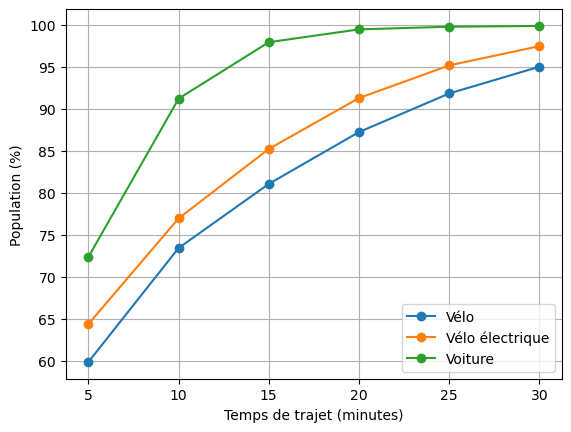

In [74]:
series_bike = results_bike / population_france * 100
series_bikee = results_bikee / population_france * 100
series_car = results_car / population_france * 100

plt.plot(series_bike, 'o-', label="Vélo")
plt.plot(series_bikee, 'o-', label="Vélo électrique")
plt.plot(series_car, 'o-', label="Voiture")
plt.xticks([0, 1, 2, 3, 4, 5], [5, 10, 15, 20, 25, 30])
plt.grid()

plt.xlabel("Temps de trajet (minutes)")
plt.ylabel("Population (%)")
plt.legend()
plt.show()

In [17]:
results_bike = compute_results(population_france, 'cycling-regular', shop_type)
results_bike

Population à 5 minutes d'une boulangerie en vélo : 69.90%
Population à 10 minutes d'une boulangerie en vélo : 82.19%
Population à 15 minutes d'une boulangerie en vélo : 89.52%
Population à 20 minutes d'une boulangerie en vélo : 94.15%
Population à 25 minutes d'une boulangerie en vélo : 96.80%
Population à 30 minutes d'une boulangerie en vélo : 98.29%


[np.float64(45040666.49345315),
 np.float64(52961252.629629605),
 np.float64(57682896.856882095),
 np.float64(60666006.53897755),
 np.float64(62376199.0510117),
 np.float64(63336596.130242184)]

In [18]:
results_bikee = compute_results(population_france, 'cycling-electric', shop_type)
results_bikee

Population à 5 minutes d'une boulangerie en vélo électrique : 73.33%
Population à 10 minutes d'une boulangerie en vélo électrique : 85.65%
Population à 15 minutes d'une boulangerie en vélo électrique : 92.71%
Population à 20 minutes d'une boulangerie en vélo électrique : 96.49%
Population à 25 minutes d'une boulangerie en vélo électrique : 98.34%
Population à 30 minutes d'une boulangerie en vélo électrique : 99.20%


[np.float64(47253600.089173496),
 np.float64(55189539.51724404),
 np.float64(59742234.695993796),
 np.float64(62173869.83757268),
 np.float64(63369865.79682327),
 np.float64(63924155.812379844)]

In [20]:
results_car = compute_results(population_france, 'driving-car', shop_type)
results_car

Population à 5 minutes d'une boulangerie en voiture : 83.17%
Population à 10 minutes d'une boulangerie en voiture : 96.74%
Population à 15 minutes d'une boulangerie en voiture : 99.35%
Population à 20 minutes d'une boulangerie en voiture : 99.78%
Population à 25 minutes d'une boulangerie en voiture : 99.86%
Population à 30 minutes d'une boulangerie en voiture : 99.89%


[np.float64(53592502.90238838),
 np.float64(62333479.07625993),
 np.float64(64017791.130888216),
 np.float64(64295553.14005816),
 np.float64(64346534.09142055),
 np.float64(64366132.99062111)]

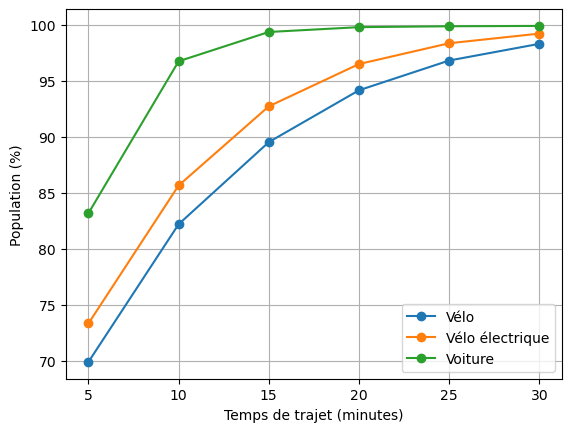

In [21]:
series_bike = results_bike / population_france * 100
series_bikee = results_bikee / population_france * 100
series_car = results_car / population_france * 100

plt.plot(series_bike, 'o-', label="Vélo")
plt.plot(series_bikee, 'o-', label="Vélo électrique")
plt.plot(series_car, 'o-', label="Voiture")
plt.xticks([0, 1, 2, 3, 4, 5], [5, 10, 15, 20, 25, 30])
plt.grid()

plt.xlabel("Temps de trajet (minutes)")
plt.ylabel("Population (%)")
plt.legend()
plt.show()

# Partie 4 : Recoupement des isochrones par commune

Cette partie permet de pousser plus loin les résultats de la partie précédente : au lieu d'obtenir des données sur la population de toute la France métropolitaine, nous obtenons des données pour chaque commune. Cela nous permet de mieux cerner les différences éventuelles entre les grandes villes, les villes plus petites, et les villages.

In [52]:
df = geopandas.read_file("data_ext/GEO_Contours_Communes_2025.geojson")

# Enlever les territoires hors métropole
df = df[~df["REGION_COD"].isin(["00", "01", "02", "03", "04", "06"])]
# Enlever les arrondissements de Paris, Lyon, Marseille (les villes entières sont déjà présentes)
df = df[~df["DCOE_L_LIB"].str.contains("Arrondissement")]

In [35]:
for i in df.index:
    mask = df.loc[i, "geometry"]
    if mask:
        if mask.geom_type == "GeometryCollection":
            df.loc[i, "geometry"] = mask.geoms[0]

In [36]:
df = df.reset_index(drop=True)
df_communes = df

In [ ]:
src = rasterio.open("processed/population/POP_FRANCE_METRO.tif")

for i in df_communes.index:
    mask = df_communes.iloc[i]["geometry"]
    
    if mask: #en cas de None, ex : île des faisans
        out_image, out_transform = rasterio.mask.mask(src, [mask], crop=True, all_touched=True)
        out_meta = src.meta
    
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
    
        with rasterio.open(f"processed/population/communes/{i}.tif", "w", **out_meta) as dest:
            dest.write(out_image)

In [21]:
for i in df_communes.index:
    try:
        with rasterio.open(f"processed/population/communes/{i}.tif") as src:
            pop_commune = pd.DataFrame(src.read()[0]).sum().sum()
            df.loc[i, "population"] = pop_commune
    except:
        print(f"Pas de fichier pour la commune {i}")
        continue
    if i%500 == 0:
        print(f"Step {i}", end='\r')

Pas de fichier pour la commune 20082
Pas de fichier pour la commune 29278
Pas de fichier pour la commune 29759
Step 34500

In [23]:
pop_fr = rasterio.open("processed/population/POP_FRANCE_METRO.tif")
population_france = pd.DataFrame(pop_fr.read()[0]).sum().sum()
population_france

np.float64(64436527.70488412)

In [22]:
df["population"].sum()

np.float64(66468207.87082209)

In [24]:
for i in df_communes.index:
    try:
        with rioxarray.open_rasterio(f"processed/population/communes/{i}.tif") as rds:
            rds.name = "data"
            pop_grille_commune = rds.to_dataframe().reset_index()

            pad = 0.000416
            s = 0
            #p_list = []
            zone_commune = df.loc[i, "geometry"]
            
            for j in pop_grille_commune.index:
                if pop_grille_commune.loc[j, "data"] > 0:
                    pop_location = pop_grille_commune.loc[j]
                    x, y = round(pop_location["x"],6), round(pop_location["y"],6)
                    p = geometry.Polygon([(x-pad, y+pad), (x+pad, y+pad), (x+pad, y-pad), (x-pad, y-pad)])
                    #p_list.append(p)
                    s += pop_location["data"]*(p.intersection(zone_commune).area / p.area)

            df_communes.loc[i, "population_2"] = s
            
    except:
        print(f"Pas de fichier pour la commune {i}")
        continue
    if i%500 == 0:
        print(f"Step {i}", end='\r')


Pas de fichier pour la commune 20082
Pas de fichier pour la commune 29278
Pas de fichier pour la commune 29759
Step 34500

In [30]:
df_communes["population"].sum()

np.float64(66468207.87082209)

In [31]:
df_communes["population_2"].sum()

np.float64(64388684.44894641)

In [68]:
df["population_2"].sum()

np.float64(63577271.60766534)

In [33]:
df_communes.to_csv(f"processed/df_pop.csv", index=False)

#### Isochrones par commune

In [6]:
shops = ('bakery', 'supermarket')
mobilities = ('driving-car', 'cycling-regular', 'cycling-electric')

liste = []
for shop in shops:
    for mobility in mobilities:
        rdf = pd.read_csv(f"processed/{mobility}/{shop}/iso_merged.csv")
        rdf["type"] = f"{shop}_{mobility}"
        liste.append(rdf)

In [7]:
rdf = geopandas.GeoDataFrame(pd.concat(liste))
rdf['geometry'] = rdf['geometry'].apply(wkt.loads)
rdf = rdf.drop(columns=["area"]).reset_index()
rdf_isochrones = rdf.set_geometry("geometry")
rdf_isochrones = rdf_isochrones.set_crs('epsg:4326')

In [8]:
len(rdf_isochrones)

36

In [11]:
df = pd.read_csv(f"processed/data/pop_iso_communes.csv", engine="python")
df = df.fillna({"geometry": "POLYGON EMPTY"})
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf_communes = geopandas.GeoDataFrame(df, crs='epsg:4326')

In [5]:
# Selon les données qui ont besoin d'être calculées, cette partie peut être très lente à calculer.

pad = 0.000416
size_rdf = len(rdf_isochrones)

for i in gdf_communes.index:
    try:
        with rioxarray.open_rasterio(f"processed/population/communes/{i}.tif") as rds:
            rds.name = "data"
            pop_grille_commune = rds.to_dataframe().reset_index()
        
            zone_commune = gdf_communes.loc[i, "geometry"]
            
            liste_iso = []
            s = [0] * size_rdf

            list_p = []
            for iso_i in range(size_rdf):
                isochrone = zone_commune.intersection(rdf_isochrones.loc[iso_i, "geometry"])
                liste_iso.append(isochrone)

            for j in pop_grille_commune.index:
                if pop_grille_commune.loc[j, "data"] > 0:
                    
                    pop_location = pop_grille_commune.loc[j]
                    x, y = round(pop_location["x"],6), round(pop_location["y"],6)
                    p = geometry.Polygon([(x-pad, y+pad), (x+pad, y+pad), (x+pad, y-pad), (x-pad, y-pad)])

                    list_p.append(p)
                    
                    for iso_i in range(size_rdf):
                        isochrone = liste_iso[iso_i]
                        s[iso_i] += pop_location["data"]*(p.intersection(isochrone).area / p.area)

            #print(s)

            for iso_i in range(size_rdf):
                iso = rdf_isochrones.loc[iso_i]
                label = f'{iso["type"]}_{int(iso["value"])}'
                gdf_communes.loc[i, label] = s[iso_i]

    except:
        print(f"Pas de fichier pour la commune {i}")
        continue
    if i%50 == 0:
        print(f"Step {i}", end='\r')
    if i%500 == 0 and i > 0:
        print("Saving data...")
        gdf_communes.to_csv(f"processed/data/df_pop_intermediaire.csv", index=False)
        print(f"Data saved : Step {i}")

gdf_communes.to_csv(f"processed/data/pop_iso_communes_final.csv", index=False)
print(f"Data saved. Total steps : {i}")

Saving data...
Data saved : Step 34500
Data saved. Total steps : 34745


In [28]:
df = pd.read_csv(f"processed/data/pop_iso_communes_final.csv", engine="python")
df.sort_values(by=['population'])

,DCOE_C_COD,DDEP_C_COD,DCOE_L_LIB,REGION,REGION_COD,DEPARTEMEN,EPCI,EPCI_CODE,geometry,population,...,supermarket_cycling-regular_1200,supermarket_cycling-regular_900,supermarket_cycling-regular_600,supermarket_cycling-regular_300,supermarket_cycling-electric_1800,supermarket_cycling-electric_1500,supermarket_cycling-electric_1200,supermarket_cycling-electric_900,supermarket_cycling-electric_600,supermarket_cycling-electric_300
20163,55239,55,Haumont-près-Samogneux,Grand Est,44,Meuse,Communauté d'agglomération du Grand Verdun,200049187,"POLYGON ((5.3789592 49.2558218, 5.3789592 49.2...",0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
20222,55307,55,Louvemont-Côte-du-Poivre,Grand Est,44,Meuse,Communauté d'agglomération du Grand Verdun,200049187,"POLYGON ((5.413733 49.2257816, 5.413733 49.225...",0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
20008,55050,55,Bezonvaux,Grand Est,44,Meuse,Communauté d'agglomération du Grand Verdun,200049187,"POLYGON ((5.4551813 49.2129201, 5.4551813 49.2...",0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
19997,55039,55,Beaumont-en-Verdunois,Grand Est,44,Meuse,Communauté d'agglomération du Grand Verdun,200049187,"POLYGON ((5.4253482 49.2500814, 5.4253482 49.2...",5.983278e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
20083,55139,55,Cumières-le-Mort-Homme,Grand Est,44,Meuse,Communauté d'agglomération du Grand Verdun,200049187,"POLYGON ((5.2333243 49.2236754, 5.2333243 49.2...",1.275116e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,13055,13,Marseille,Provence-Alpes-Côte d'Azur,93,Bouches-du-Rhône,Métropole d'Aix-Marseille-Provence,200054807,"POLYGON ((5.5005821 43.1976386, 5.5065469 43.1...",8.420471e+05,...,8.407708e+05,8.403828e+05,8.363822e+05,7.618284e+05,8.409630e+05,8.409568e+05,8.409035e+05,8.406422e+05,8.397955e+05,7.933879e+05
29194,75056,75,Paris,Île-de-France,11,Paris,Métropole du Grand Paris,200054781,"POLYGON ((2.3439112 48.815758, 2.3528674 48.81...",2.244008e+06,...,2.244008e+06,2.244008e+06,2.244008e+06,2.242353e+06,2.244008e+06,2.244008e+06,2.244008e+06,2.244008e+06,2.244008e+06,2.243720e+06
20082,55138,55,Culey,Grand Est,44,Meuse,Communauté d'agglomération de Bar-le-Duc - Sud...,200033025,POLYGON EMPTY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29278,76095,76,Bihorel,Normandie,28,Seine-Maritime,Métropole Rouen Normandie,200023414,POLYGON EMPTY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Visualisation

In [47]:
select = df[df["population"] < 2000]

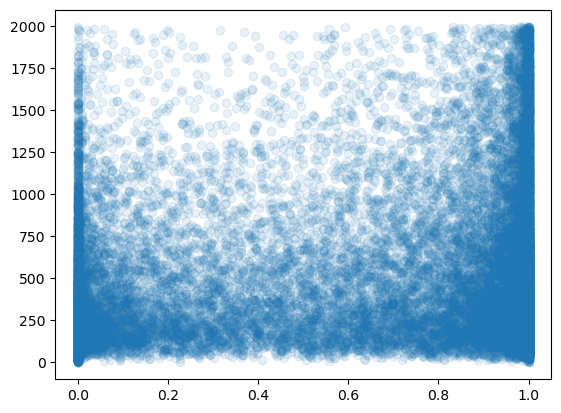

In [62]:
plt.scatter(select["supermarket_driving-car_600"]/select["population"], select["population"], alpha=0.1)
plt.show()

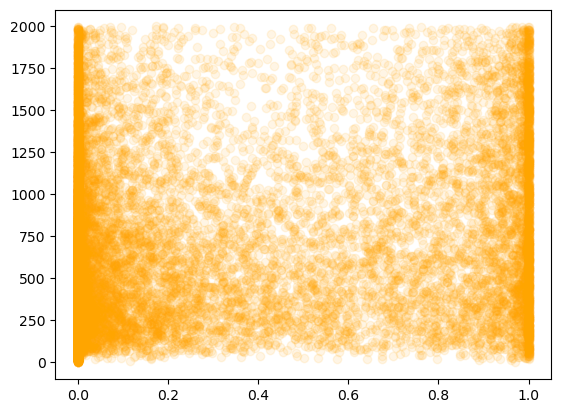

In [63]:
plt.scatter(select["supermarket_cycling-electric_600"]/select["population"], select["population"], alpha=0.1, color="orange")
plt.show()

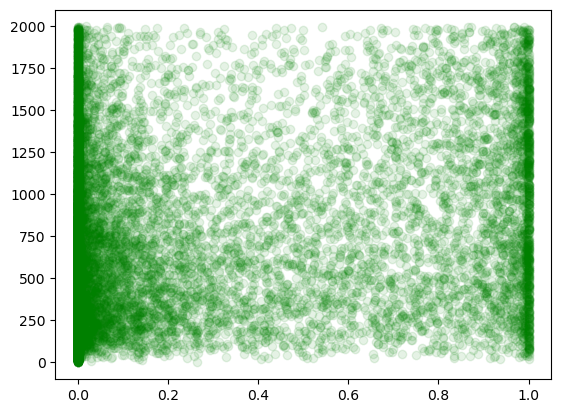

In [64]:
plt.scatter(select["supermarket_cycling-regular_600"]/select["population"], select["population"], alpha=0.1, color="green")
plt.show()